# **FER MODEL**

## IMPORT PACKAGES

In [1]:
import os
import warnings
import cv2, sys
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from collections import Counter

In [ ]:
print("Packages and Versions:")
for pkg, ver in package_versions.items():
    print(f"{pkg}: {ver}")

## IMPORT FUNCTIONS

In [2]:
from libreface.resnet18 import ResNet
from libreface.solver_inference_image import solver_inference_image
from libreface.detect_mediapipe_image import get_aligned_image

## LOAD MODEL AND WEIGHTS

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
fer_model = ResNet( num_labels=8, dropout=0.1,fm_distillation=True).to(device)

ckpt_path = "weights_libreface/Facial_Expression_Recognition/weights/resnet.pt"
ckpt = torch.load(ckpt_path, map_location=device)
fer_model.load_state_dict(ckpt["model"])
fer_model.eval()
fer_solver = solver_inference_image(student_model=fer_model,device=device,image_size=224)

## LOAD MEDIAPIPE MODEL

In [4]:
model_path = "face_land/face_landmarker.task"
BaseOptions = mp.tasks.BaseOptions
FaceLandmarker = mp.tasks.vision.FaceLandmarker
FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

options = FaceLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.IMAGE,
    num_faces=1)
landmarker = FaceLandmarker.create_from_options(options)

I0000 00:00:1770826454.646347  897627 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1770826454.649078  897701 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.3), renderer: AMD Radeon Graphics (radeonsi, renoir, LLVM 17.0.6, DRM 3.57, 6.8.0-90-generic)
W0000 00:00:1770826454.649478  897627 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1770826454.655538  897705 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1770826454.676818  897702 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


## function to crop face

In [6]:
def crop_face(img, results):
    if results.face_landmarks:
        h, w = img.shape[:2]
        l_m = results.face_landmarks[0]
        pts = np.array([(int(l.x * w), int(l.y * h)) for l in l_m])
        x, y = pts[:, 0], pts[:, 1]
        return img[y.min():y.max(), x.min():x.max()]
    else:
        return img

## function for classes and colors

In [7]:
def color(pred):
    if pred in ['Anger', 'Disgust']:
        return 'Negative', (0, 0, 255)  # Red
    elif pred in ['Happiness', 'Neutral']:
        return 'Positive', (0, 255, 0)  # Green
    elif pred in ['Surprise', 'Fear']:
        return 'Stress', (0, 175, 255)  # Light Orange
    elif pred in ['Sadness', 'Contempt']:
        return 'Worry', (0, 120, 255)  # Dark Orange

idx_to_fe = {
    0: "Neutral",
    1: "Happiness",
    2: "Sadness",
    3: "Surprise",
    4: "Fear",
    5: "Disgust",
    6: "Anger",
    7: "Contempt"}

# MEAN PREDICTION

In [ ]:
FRAME_WINDOW = 5
emotion_window = []
stable_emotion = None
cls = []
red_cls = []

In [8]:
FRAME_WINDOW = 5
emotion_window = []
stable_emotion = None
cls = []
red_cls = []
cap = cv2.VideoCapture("/home/alae/Desktop/env/notbooks/fer/3_emotion_videos/vids/filetest.avi")
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    fram = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) 
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=fram)
    results = landmarker.detect(mp_image)
    if not results.face_landmarks:
        cv2.putText(frame, 'No face', (30, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        continue
    else:
        align = get_aligned_image(fram, results, verbose=False)
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=align)
        results = landmarker.detect(mp_image)
        face = crop_face(align, results)
        facial_expression_idx, conf = fer_solver.run(face)
        emotion_window.append(idx_to_fe[facial_expression_idx])
        if len(emotion_window) == FRAME_WINDOW:
            stable_emotion = Counter(emotion_window).most_common(1)[0][0]
            emotion_window.clear()
        if stable_emotion is not None:
            emo, col = color(stable_emotion)
            red_cls.append(emo)
            cls.append(stable_emotion)
            cv2.putText(frame,f"{emo}",(30, 30),cv2.FONT_HERSHEY_SIMPLEX,0.9,col,2)
            cv2.putText(frame, stable_emotion, (30, 60),cv2.FONT_HERSHEY_SIMPLEX, 1,col, 2)
        cv2.imshow("LibreFace Expression", frame)
        cv2.imshow("LibreFace", face)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
cap.release()
cv2.destroyAllWindows()

# MEAN PREDICTION 2

In [20]:
FRAME_WINDOW = 5
emotion_window = []
stable_emotion = None
cls = []
red_cls = []

In [23]:
cap = cv2.VideoCapture("/home/alae/Desktop/env/notbooks/fer/3_emotion_videos/vids/filetest.avi")
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    fram = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=fram)
    results = landmarker.detect(mp_image)
    if not results.face_landmarks:
        cv2.putText(frame, 'No face', (30, 40),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.imshow("LibreFace Expression", frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
        continue
    align = get_aligned_image(fram, results, verbose=False)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=align)
    results = landmarker.detect(mp_image)
    face = crop_face(align, results)
    facial_expression_idx, conf = fer_solver.run(face)
    pred = idx_to_fe[facial_expression_idx]
    # SLIDING WINDOW
    emotion_window.append(pred)
    if len(emotion_window) > FRAME_WINDOW:
        emotion_window.pop(0)  # remove oldest
    # majority vote EVERY frame
    stable_emotion = Counter(emotion_window).most_common(1)[0][0]
    emo, col = color(stable_emotion)
    red_cls.append(emo)
    cls.append(stable_emotion)
    cv2.putText(frame, emo, (30, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.9, col, 2)
    cv2.putText(frame, stable_emotion, (30,60),cv2.FONT_HERSHEY_SIMPLEX, 1, col, 2)
    cv2.imshow("LibreFace Expression", frame)
    cv2.imshow("LibreFace", face)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
cap.release()
cv2.destroyAllWindows()

# PLOT RESULTS IN PERCENTAGE

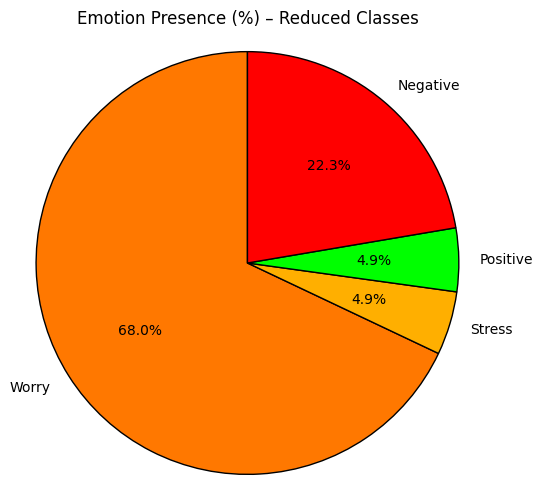

In [9]:
def compute_percentages(labels):
    counter = Counter(labels)
    total = sum(counter.values())
    labels = list(counter.keys())
    percentages = [100 * counter[l] / total for l in labels]
    return labels, percentages
labels, percentages = compute_percentages(red_cls)
REDUCED_COLOR_MAP = {
    'Positive': (0/255, 255/255, 0/255),      # Green
    'Negative': (255/255, 0/255, 0/255),      # Red
    'Stress':   (255/255, 175/255, 0/255),    # Light Orange
    'Worry':    (255/255, 120/255, 0/255)}    # Dark Orange
colors = [REDUCED_COLOR_MAP[l] for l in labels]
plt.figure(figsize=(6,6))
plt.pie(percentages,labels=labels,colors=colors,autopct='%1.1f%%',
        startangle=90,wedgeprops={'edgecolor': 'black'})
plt.title("Emotion Presence (%) – Reduced Classes")
plt.axis('equal')
plt.show()

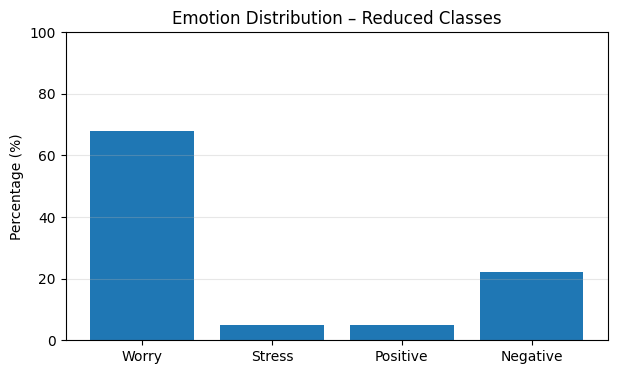

In [10]:
plt.figure(figsize=(7,4))
plt.bar(labels, percentages)
plt.ylabel("Percentage (%)")
plt.title("Emotion Distribution – Reduced Classes")
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3)
plt.show()

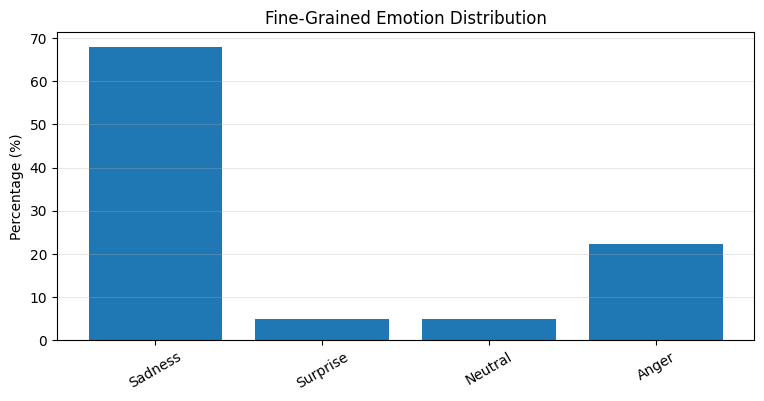

In [11]:
labels_f, percentages_f = compute_percentages(cls)
plt.figure(figsize=(9,4))
plt.bar(labels_f, percentages_f)
plt.ylabel("Percentage (%)")
plt.title("Fine-Grained Emotion Distribution")
plt.xticks(rotation=30)
plt.grid(axis='y', alpha=0.3)
plt.show()